# Binary Classification for MEV Detection

## Overview

This notebook converts the multi-class MEV detection problem to **binary classification** (MEV = 1, Non-MEV = 0) to better handle imbalanced data and improve model performance.

### Why Binary Classification?

1. **Handles Imbalance Better**: MEV class (~20k / 5.5M) is still minority, but binary classification makes weighting/sampling simpler
2. **Model Simplification**: SVM/Logistic won't skip (classes = 2). GMM/Isolation Forest still applicable (anomaly = MEV)
3. **Better Evaluation**: Use PR-AUC or F1 (MEV class), ignore accuracy for imbalanced data
4. **Aggregates Non-MEV**: All other classes (Aggregator, Wash Trading, Regular) become Non-MEV, making majority class more stable

### Dataset

**Source**: `pamm_clean_final.parquet` (5.5M+ transaction records)

**Features**: 
- `total_trades`, `trades_per_hour`, `aggregator_likelihood`
- `late_slot_ratio`, `oracle_backrun_ratio`, `high_bytes_ratio`
- `cluster_ratio`, `mev_score`, `wash_trading_score`

**Binary Labels**:
- **MEV (1)**: `LIKELY MEV BOT`, `POSSIBLE MEV`
- **Non-MEV (0)**: `LIKELY AGGREGATOR`, `LIKELY WASH TRADING`, `REGULAR TRADE BOT`

### Methods Tested

1. **Gaussian Mixture Model (GMM)** - Unsupervised clustering (n_components=2)
2. **Isolation Forest** - Unsupervised anomaly detection (contamination = MEV ratio)
3. **Random Forest** - Supervised classification with class weights
4. **XGBoost** - Advanced gradient boosting with scale_pos_weight
5. **Support Vector Machine (SVM)** - Decision boundary optimization
6. **Logistic Regression** - Interpretable linear baseline

### Key Improvements

- **SMOTE Oversampling**: Balances training data (target ratio 1:2 MEV:Non-MEV)
- **Class Weights**: All models use balanced weights or scale_pos_weight
- **PR-AUC Focus**: Precision-Recall curves for imbalanced data
- **Monte Carlo Simulation**: Bootstrap validation for model stability
- **Parameter Optimization**: GridSearchCV for hyperparameter tuning

### Target Metrics

- **MEV Recall > 0.7**: Catch most MEV bots
- **MEV F1 > 0.5**: Balanced precision and recall
- **PR-AUC > 0.6**: Good performance on imbalanced data

In [1]:
"""
Binary Classification for MEV Detection
Converts multi-class classification to binary (MEV = 1, Non-MEV = 0)
"""
# Install required packages if missing
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# Check and install imbalanced-learn if needed
try:
    import imblearn
except ImportError:
    print("Installing imbalanced-learn...")
    install_package("imbalanced-learn")
    print("✓ imbalanced-learn installed successfully")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, PrecisionRecallDisplay, average_precision_score
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import os
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Create output directory
os.makedirs('derived/ml_results_binary', exist_ok=True)

print("="*80)
print("BINARY CLASSIFICATION FOR MEV DETECTION")
print("="*80)

BINARY CLASSIFICATION FOR MEV DETECTION


## 1. Data Loading and Binary Label Conversion

### What This Section Does:

1. **Loads Transaction Data**: Reads the cleaned parquet file with 5.5M+ transaction records
2. **Feature Engineering**: Creates signer-level features (same as original notebook)
3. **Binary Label Conversion**: Converts multi-class labels to binary (MEV=1, Non-MEV=0)
4. **Class Distribution Analysis**: Shows imbalance ratio and distribution

### Binary Label Mapping:

- **MEV (1)**: `LIKELY MEV BOT`, `POSSIBLE MEV (Sandwich patterns)`, `POSSIBLE MEV (Cluster patterns)`
- **Non-MEV (0)**: `LIKELY AGGREGATOR`, `LIKELY WASH TRADING`, `REGULAR TRADE BOT / UNKNOWN`

In [2]:
print("="*80)
print("1. DATA LOADING AND BINARY LABEL CONVERSION")
print("="*80)
print()

# Load cleaned transaction data
print("Loading cleaned transaction data...")
try:
    # Try multiple possible paths
    possible_paths = [
        '../01_data_cleaning/outputs/pamm_clean_final.parquet',
        '../../01_data_cleaning/outputs/pamm_clean_final.parquet',
        '/Users/aileen/Downloads/pamm/pamm_clean_final.parquet',
        'pamm_clean_final.parquet'
    ]
    
    df_clean = None
    for path in possible_paths:
        try:
            df_clean = pd.read_parquet(path)
            print(f"✓ Loaded from: {path}")
            break
        except:
            continue
    
    if df_clean is None:
        raise FileNotFoundError("Could not find pamm_clean_final.parquet in any expected location")
    
    print(f"✓ Loaded {len(df_clean):,} transaction records")
    print(f"✓ Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
    print(f"✓ Event types: {df_clean['kind'].value_counts().to_dict()}")
    print()
    
    # Filter to TRADE events only
    df_trades = df_clean[df_clean['kind'] == 'TRADE'].copy()
    print(f"✓ TRADE events: {len(df_trades):,} records")
    print(f"✓ Unique signers: {df_trades['signer'].nunique():,}")
    print()
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Feature Engineering (same as original notebook)
print("Engineering features from transaction data...")
print("This may take a few minutes for large datasets...")

signer_features = []
unique_signers = df_trades['signer'].unique()
print(f"Processing {len(unique_signers):,} unique signers...")

# Sample if too large
if len(unique_signers) > 5000:
    print(f"⚠️  Large dataset detected. Sampling 5,000 signers for faster processing...")
    np.random.seed(42)
    unique_signers = np.random.choice(unique_signers, size=5000, replace=False)
    print(f"Processing {len(unique_signers):,} sampled signers...")

print("Processing signers...")
for i, signer in enumerate(unique_signers):
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(unique_signers)} signers...")
    signer_trades = df_trades[df_trades['signer'] == signer].copy()
    
    if len(signer_trades) < 2:
        continue
    
    total_trades = len(signer_trades)
    time_span_hours = (signer_trades['datetime'].max() - signer_trades['datetime'].min()).total_seconds() / 3600
    trades_per_hour = total_trades / max(time_span_hours, 0.1)
    
    late_slot_trades = (signer_trades['us_since_first_shred'] > 300000).sum()
    late_slot_ratio = late_slot_trades / total_trades
    
    signer_slots = signer_trades['slot'].unique()
    oracle_backrun_count = 0
    slot_oracles = df_clean[(df_clean['slot'].isin(signer_slots)) & 
                           (df_clean['kind'] == 'ORACLE')][['slot', 'ms_time']]
    
    if len(slot_oracles) > 0:
        oracle_by_slot = slot_oracles.groupby('slot')['ms_time'].apply(list).to_dict()
        for _, trade in signer_trades.iterrows():
            slot = trade['slot']
            trade_time = trade['ms_time']
            if slot in oracle_by_slot:
                oracle_times = oracle_by_slot[slot]
                time_diffs = [abs(ot - trade_time) for ot in oracle_times]
                if min(time_diffs) < 50:
                    oracle_backrun_count += 1
    oracle_backrun_ratio = oracle_backrun_count / total_trades if total_trades > 0 else 0
    
    high_bytes_trades = (signer_trades['bytes_changed_trade'] > 50).sum()
    high_bytes_ratio = high_bytes_trades / total_trades if total_trades > 0 else 0
    
    slot_counts = signer_trades.groupby('slot').size()
    clustered_slots = (slot_counts >= 2).sum()
    cluster_ratio = clustered_slots / signer_trades['slot'].nunique() if signer_trades['slot'].nunique() > 0 else 0
    
    signer_slots = signer_trades['slot'].unique()
    sample_size = min(100, len(signer_slots))
    
    if sample_size > 0:
        sampled_slots = np.random.choice(signer_slots, size=sample_size, replace=False)
        slot_trade_counts = df_trades[df_trades['slot'].isin(sampled_slots)].groupby('slot').agg({
            'signer': ['count', 'nunique']
        }).reset_index()
        slot_trade_counts.columns = ['slot', 'total_trades', 'unique_signers']
        slot_trade_counts = slot_trade_counts[slot_trade_counts['total_trades'] > 1]
        
        if len(slot_trade_counts) > 0:
            slot_trade_counts['unique_ratio'] = slot_trade_counts['unique_signers'] / slot_trade_counts['total_trades']
            aggregator_slots = (slot_trade_counts['unique_ratio'] > 0.7).sum()
            aggregator_likelihood = aggregator_slots / len(slot_trade_counts)
        else:
            aggregator_likelihood = 0
    else:
        aggregator_likelihood = 0
    
    mev_score = (late_slot_ratio * 0.3 + 
                 oracle_backrun_ratio * 0.3 + 
                 high_bytes_ratio * 0.2 + 
                 cluster_ratio * 0.2)
    
    wash_trading_score = trades_per_hour / max(mev_score + 0.1, 0.1)
    
    # Classification logic
    if aggregator_likelihood > 0.5:
        classification = "LIKELY AGGREGATOR (Jupiter, etc.)"
    elif wash_trading_score > 1.0 and mev_score < 0.2:
        classification = "LIKELY WASH TRADING (Volume Inflation)"
    elif mev_score > 0.3:
        classification = "LIKELY MEV BOT"
    elif cluster_ratio > 0.3:
        classification = "POSSIBLE MEV (Sandwich patterns)"
    else:
        classification = "REGULAR TRADE BOT / UNKNOWN"
    
    signer_features.append({
        'signer': signer,
        'total_trades': total_trades,
        'trades_per_hour': trades_per_hour,
        'aggregator_likelihood': aggregator_likelihood,
        'late_slot_ratio': late_slot_ratio,
        'oracle_backrun_ratio': oracle_backrun_ratio,
        'high_bytes_ratio': high_bytes_ratio,
        'cluster_ratio': cluster_ratio,
        'mev_score': mev_score,
        'wash_trading_score': wash_trading_score,
        'classification': classification
    })

df = pd.DataFrame(signer_features)
print(f"✓ Created features for {len(df)} signers")
print()

# Feature selection
feature_cols = [
    'total_trades', 'trades_per_hour', 'aggregator_likelihood',
    'late_slot_ratio', 'oracle_backrun_ratio', 'high_bytes_ratio',
    'cluster_ratio', 'mev_score', 'wash_trading_score'
]

df_clean_features = df[feature_cols + ['classification']].dropna()

if len(df_clean_features) == 0:
    raise ValueError("❌ Error: No data remaining after cleaning.")

print(f"✓ Cleaned dataset: {len(df_clean_features)} records")
print(f"✓ Features: {len(feature_cols)}")
print()

# ============================================================================
# BINARY LABEL CONVERSION
# ============================================================================
print("Converting multi-class labels to binary...")

# Define MEV labels (class = 1)
mev_labels = [
    'LIKELY MEV BOT',
    'POSSIBLE MEV (Sandwich patterns)',
    'POSSIBLE MEV (Cluster patterns)',
    'LIKELY MEV BOT (Fat Sandwich)'
]

# Create binary label: 1 = MEV, 0 = Non-MEV
df_clean_features['binary_label'] = df_clean_features['classification'].apply(
    lambda x: 1 if x in mev_labels else 0
)

# Check distribution
print("\nBinary Class Distribution:")
binary_dist = Counter(df_clean_features['binary_label'])
for label, count in sorted(binary_dist.items()):
    label_name = 'MEV' if label == 1 else 'Non-MEV'
    print(f"  {label_name} ({label}): {count:,} samples ({count/len(df_clean_features)*100:.2f}%)")

imbalance_ratio = binary_dist[0] / binary_dist[1] if 1 in binary_dist else float('inf')
print(f"\nImbalance Ratio (Non-MEV:MEV): {imbalance_ratio:.2f}:1")

# Prepare X and y
X = df_clean_features[feature_cols]
y = df_clean_features['binary_label'].values

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Labels shape: {y.shape}")
print(f"✓ MEV samples: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"✓ Non-MEV samples: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print()

1. DATA LOADING AND BINARY LABEL CONVERSION

Loading cleaned transaction data...
✓ Loaded from: ../01_data_cleaning/outputs/pamm_clean_final.parquet
✓ Loaded 5,506,090 transaction records
✓ Time range: 1970-01-30 10:19:36.344000+00:00 to 1970-01-30 21:21:51.678000+00:00
✓ Event types: {'ORACLE': 4822262, 'TRADE': 683828}

✓ TRADE events: 683,828 records
✓ Unique signers: 57,271

Engineering features from transaction data...
This may take a few minutes for large datasets...
Processing 57,271 unique signers...
⚠️  Large dataset detected. Sampling 5,000 signers for faster processing...
Processing 5,000 sampled signers...
Processing signers...
  Processed 500/5000 signers...
  Processed 1000/5000 signers...
  Processed 1500/5000 signers...
  Processed 2000/5000 signers...
  Processed 2500/5000 signers...
  Processed 3000/5000 signers...
  Processed 3500/5000 signers...
  Processed 4000/5000 signers...
  Processed 4500/5000 signers...
  Processed 5000/5000 signers...
✓ Created features for 

## 2. SMOTE Oversampling and Train/Test Split

### What This Section Does:

1. **Train/Test Split**: Splits data 80/20 with stratification
2. **SMOTE Oversampling**: Balances training data (target ratio 1:2 MEV:Non-MEV)
3. **Feature Scaling**: Standardizes features for better model performance

### SMOTE Configuration:

- **sampling_strategy=0.5**: Target ratio of MEV:Non-MEV = 1:2 (instead of 1:10+)
- This helps models learn MEV patterns without overfitting

In [3]:
print("="*80)
print("2. SMOTE OVERSAMPLING AND TRAIN/TEST SPLIT")
print("="*80)
print()

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"  - MEV: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"  - Non-MEV: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"\nTest set: {len(X_test)} samples")
print(f"  - MEV: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")
print(f"  - Non-MEV: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
print()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for binary classification
print("Applying SMOTE oversampling...")
print(f"Before SMOTE - Training distribution: {Counter(y_train)}")

# SMOTE with sampling_strategy=0.5 (target ratio MEV:Non-MEV = 1:2)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Training distribution: {Counter(y_train_res)}")
print(f"  - MEV: {np.sum(y_train_res == 1)} ({np.sum(y_train_res == 1)/len(y_train_res)*100:.2f}%)")
print(f"  - Non-MEV: {np.sum(y_train_res == 0)} ({np.sum(y_train_res == 0)/len(y_train_res)*100:.2f}%)")
print()

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = Counter(y_train_res)[0] / Counter(y_train_res)[1] if Counter(y_train_res)[1] > 0 else 1
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")
print()

2. SMOTE OVERSAMPLING AND TRAIN/TEST SPLIT

Training set: 2052 samples
  - MEV: 162 (7.89%)
  - Non-MEV: 1890 (92.11%)

Test set: 514 samples
  - MEV: 40 (7.78%)
  - Non-MEV: 474 (92.22%)

Applying SMOTE oversampling...
Before SMOTE - Training distribution: Counter({np.int64(0): 1890, np.int64(1): 162})
After SMOTE - Training distribution: Counter({np.int64(0): 1890, np.int64(1): 945})
  - MEV: 945 (33.33%)
  - Non-MEV: 1890 (66.67%)

XGBoost scale_pos_weight: 2.00



## 3. Model Training - Binary Classification

### Models:

1. **Random Forest** - With class_weight='balanced'
2. **XGBoost** - With scale_pos_weight for imbalanced data
3. **SVM** - With class_weight='balanced'
4. **Logistic Regression** - With class_weight='balanced'
5. **GMM** - Unsupervised clustering (n_components=2)
6. **Isolation Forest** - Anomaly detection (contamination = MEV ratio)

In [4]:
print("="*80)
print("3. MODEL TRAINING - BINARY CLASSIFICATION")
print("="*80)
print()

# Store all models and predictions
models = {}
predictions = {}
probabilities = {}

# ============================================================================
# 1. RANDOM FOREST
# ============================================================================
print("1. RANDOM FOREST")
print("-" * 80)

rf = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced',
    random_state=42,
    max_depth=10
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

models['Random Forest'] = rf
predictions['Random Forest'] = y_pred_rf
probabilities['Random Forest'] = y_proba_rf

print("✓ Training complete")
print(f"  - Train Accuracy: {rf.score(X_train_res, y_train_res):.4f}")
print(f"  - Test Accuracy: {rf.score(X_test_scaled, y_test):.4f}")
print()

# ============================================================================
# 2. XGBOOST
# ============================================================================
print("2. XGBOOST")
print("-" * 80)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss'
)
xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

models['XGBoost'] = xgb_model
predictions['XGBoost'] = y_pred_xgb
probabilities['XGBoost'] = y_proba_xgb

print("✓ Training complete")
print(f"  - Train Accuracy: {xgb_model.score(X_train_res, y_train_res):.4f}")
print(f"  - Test Accuracy: {xgb_model.score(X_test_scaled, y_test):.4f}")
print()

# ============================================================================
# 3. SVM
# ============================================================================
print("3. SUPPORT VECTOR MACHINE (SVM)")
print("-" * 80)

svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm.fit(X_train_res, y_train_res)

y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

models['SVM'] = svm
predictions['SVM'] = y_pred_svm
probabilities['SVM'] = y_proba_svm

print("✓ Training complete")
print(f"  - Train Accuracy: {svm.score(X_train_res, y_train_res):.4f}")
print(f"  - Test Accuracy: {svm.score(X_test_scaled, y_test):.4f}")
print()

# ============================================================================
# 4. LOGISTIC REGRESSION
# ============================================================================
print("4. LOGISTIC REGRESSION")
print("-" * 80)

lr = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

models['Logistic Regression'] = lr
predictions['Logistic Regression'] = y_pred_lr
probabilities['Logistic Regression'] = y_proba_lr

print("✓ Training complete")
print(f"  - Train Accuracy: {lr.score(X_train_res, y_train_res):.4f}")
print(f"  - Test Accuracy: {lr.score(X_test_scaled, y_test):.4f}")
print()

# ============================================================================
# 5. GAUSSIAN MIXTURE MODEL (GMM)
# ============================================================================
print("5. GAUSSIAN MIXTURE MODEL (GMM)")
print("-" * 80)

# For binary classification, use n_components=2
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train_res)

# Predict clusters
train_clusters = gmm.predict(X_train_res)
test_clusters = gmm.predict(X_test_scaled)

# Map clusters to binary labels using majority voting
cluster_to_label = {}
for cluster_id in range(2):
    cluster_mask = (train_clusters == cluster_id)
    cluster_labels = y_train_res[cluster_mask]
    if len(cluster_labels) > 0:
        most_common_label = np.bincount(cluster_labels).argmax()
        cluster_to_label[cluster_id] = most_common_label
    else:
        cluster_to_label[cluster_id] = 0

# Map test clusters to binary labels
y_pred_gmm = np.array([cluster_to_label.get(c, 0) for c in test_clusters])

# Get probabilities (use log probabilities)
log_proba = gmm.score_samples(X_test_scaled)
# Normalize to [0, 1] range for probability
y_proba_gmm = 1 / (1 + np.exp(-log_proba))  # Simple sigmoid transformation

models['GMM'] = gmm
predictions['GMM'] = y_pred_gmm
probabilities['GMM'] = y_proba_gmm

print("✓ Training complete")
print(f"  - Cluster-to-label mapping: {cluster_to_label}")
print(f"  - Test Accuracy: {accuracy_score(y_test, y_pred_gmm):.4f}")
print()

# ============================================================================
# 6. ISOLATION FOREST
# ============================================================================
print("6. ISOLATION FOREST")
print("-" * 80)

# Set contamination to MEV ratio
mev_ratio = np.sum(y_train_res == 1) / len(y_train_res)
iso_forest = IsolationForest(
    contamination=mev_ratio,
    random_state=42
)
iso_forest.fit(X_train_res)

# Predict anomalies (-1 = anomaly/MEV, 1 = normal/Non-MEV)
test_anomalies = iso_forest.predict(X_test_scaled)
# Convert to binary: -1 -> 1 (MEV), 1 -> 0 (Non-MEV)
y_pred_iso = (test_anomalies == -1).astype(int)

# Get anomaly scores (lower = more anomalous)
anomaly_scores = iso_forest.score_samples(X_test_scaled)
# Normalize scores to probabilities (lower scores = higher MEV probability)
y_proba_iso = 1 / (1 + np.exp(anomaly_scores))  # Inverse sigmoid

models['Isolation Forest'] = iso_forest
predictions['Isolation Forest'] = y_pred_iso
probabilities['Isolation Forest'] = y_proba_iso

print("✓ Training complete")
print(f"  - Contamination rate: {mev_ratio:.4f}")
print(f"  - Test Accuracy: {accuracy_score(y_test, y_pred_iso):.4f}")
print()

print("="*80)
print("ALL MODELS TRAINED")
print("="*80)
print()

3. MODEL TRAINING - BINARY CLASSIFICATION

1. RANDOM FOREST
--------------------------------------------------------------------------------
✓ Training complete
  - Train Accuracy: 1.0000
  - Test Accuracy: 1.0000

2. XGBOOST
--------------------------------------------------------------------------------
✓ Training complete
  - Train Accuracy: 1.0000
  - Test Accuracy: 1.0000

3. SUPPORT VECTOR MACHINE (SVM)
--------------------------------------------------------------------------------
✓ Training complete
  - Train Accuracy: 0.9968
  - Test Accuracy: 0.9922

4. LOGISTIC REGRESSION
--------------------------------------------------------------------------------
✓ Training complete
  - Train Accuracy: 0.9929
  - Test Accuracy: 0.9922

5. GAUSSIAN MIXTURE MODEL (GMM)
--------------------------------------------------------------------------------
✓ Training complete
  - Cluster-to-label mapping: {0: np.int64(0), 1: np.int64(1)}
  - Test Accuracy: 0.9416

6. ISOLATION FOREST
-----------

## 4. Model Evaluation - Binary Classification Metrics

### Metrics for Imbalanced Data:

- **Precision (MEV)**: Of predicted MEV, how many are actually MEV?
- **Recall (MEV)**: Of actual MEV, how many did we catch?
- **F1-Score (MEV)**: Harmonic mean of precision and recall
- **PR-AUC**: Area under Precision-Recall curve (better than ROC-AUC for imbalanced data)
- **ROC-AUC**: Area under ROC curve

### Target Goals:

- **MEV Recall > 0.7**: Catch most MEV bots
- **MEV F1 > 0.5**: Balanced precision and recall
- **PR-AUC > 0.6**: Good performance on imbalanced data

In [5]:
print("="*80)
print("4. MODEL EVALUATION - BINARY CLASSIFICATION METRICS")
print("="*80)
print()

# Calculate metrics for each model
results = []

for model_name in models.keys():
    y_pred = predictions[model_name]
    y_proba = probabilities[model_name]
    
    # Binary classification metrics
    precision_mev = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_mev = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_mev = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    # ROC-AUC and PR-AUC
    try:
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = 0.0
    
    try:
        pr_auc = average_precision_score(y_test, y_proba)
    except:
        pr_auc = 0.0
    
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision_mev': precision_mev,
        'recall_mev': recall_mev,
        'f1_mev': f1_mev,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    })
    
    print(f"{model_name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - MEV Precision: {precision_mev:.4f}")
    print(f"  - MEV Recall: {recall_mev:.4f}")
    print(f"  - MEV F1: {f1_mev:.4f}")
    print(f"  - ROC-AUC: {roc_auc:.4f}")
    print(f"  - PR-AUC: {pr_auc:.4f}")
    print()
    
    # Classification report
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-MEV', 'MEV'], zero_division=0))
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)
print("="*80)
print("SUMMARY - ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))
print()

# Find best model by F1 (MEV)
best_model_f1 = results_df.loc[results_df['f1_mev'].idxmax(), 'model']
best_f1 = results_df.loc[results_df['f1_mev'].idxmax(), 'f1_mev']
print(f"Best model by MEV F1: {best_model_f1} (F1={best_f1:.4f})")

# Find best model by PR-AUC
best_model_pr = results_df.loc[results_df['pr_auc'].idxmax(), 'model']
best_pr = results_df.loc[results_df['pr_auc'].idxmax(), 'pr_auc']
print(f"Best model by PR-AUC: {best_model_pr} (PR-AUC={best_pr:.4f})")
print()

4. MODEL EVALUATION - BINARY CLASSIFICATION METRICS

Random Forest:
  - Accuracy: 1.0000
  - MEV Precision: 1.0000
  - MEV Recall: 1.0000
  - MEV F1: 1.0000
  - ROC-AUC: 1.0000
  - PR-AUC: 1.0000

  Classification Report:
              precision    recall  f1-score   support

     Non-MEV       1.00      1.00      1.00       474
         MEV       1.00      1.00      1.00        40

    accuracy                           1.00       514
   macro avg       1.00      1.00      1.00       514
weighted avg       1.00      1.00      1.00       514


XGBoost:
  - Accuracy: 1.0000
  - MEV Precision: 1.0000
  - MEV Recall: 1.0000
  - MEV F1: 1.0000
  - ROC-AUC: 1.0000
  - PR-AUC: 1.0000

  Classification Report:
              precision    recall  f1-score   support

     Non-MEV       1.00      1.00      1.00       474
         MEV       1.00      1.00      1.00        40

    accuracy                           1.00       514
   macro avg       1.00      1.00      1.00       514
weighted avg   

Creating visualizations...
✓ Saved: confusion_matrices.png


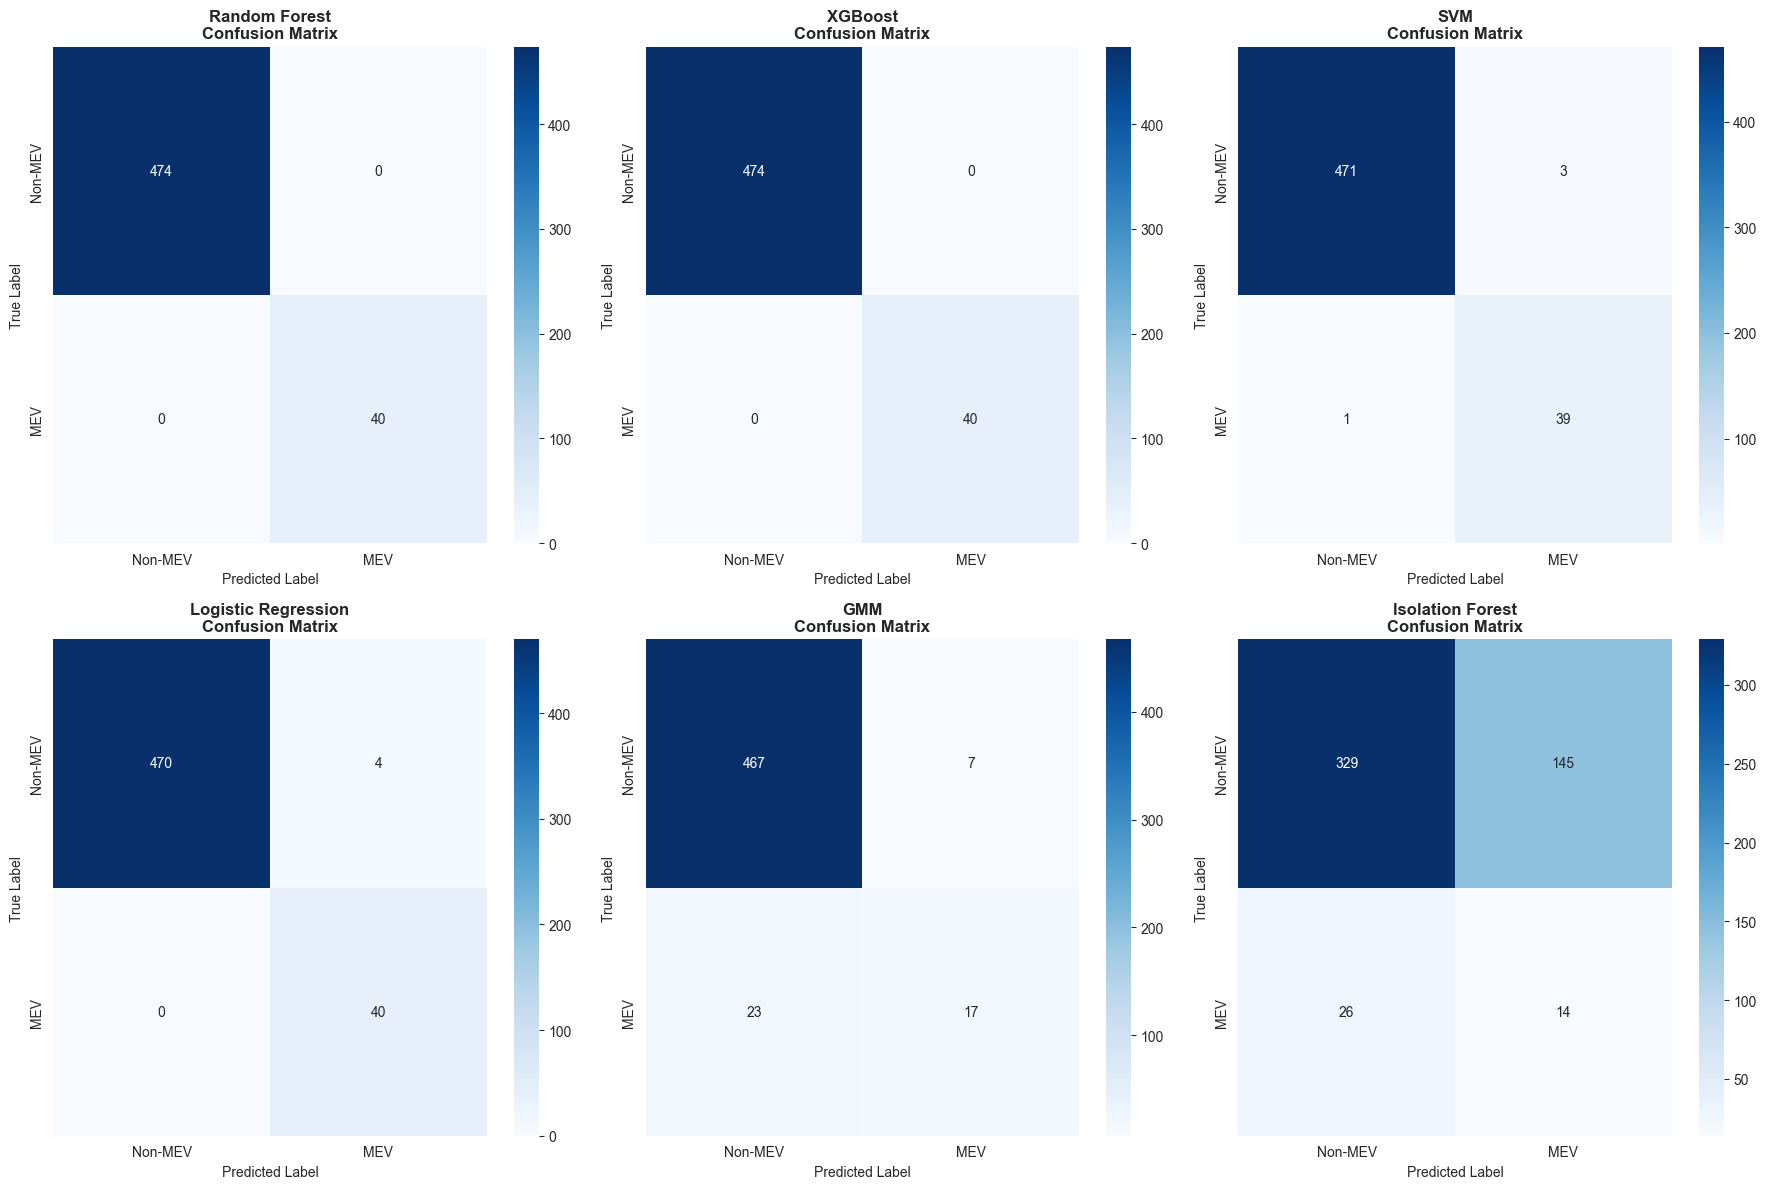

✓ Saved: pr_curves.png


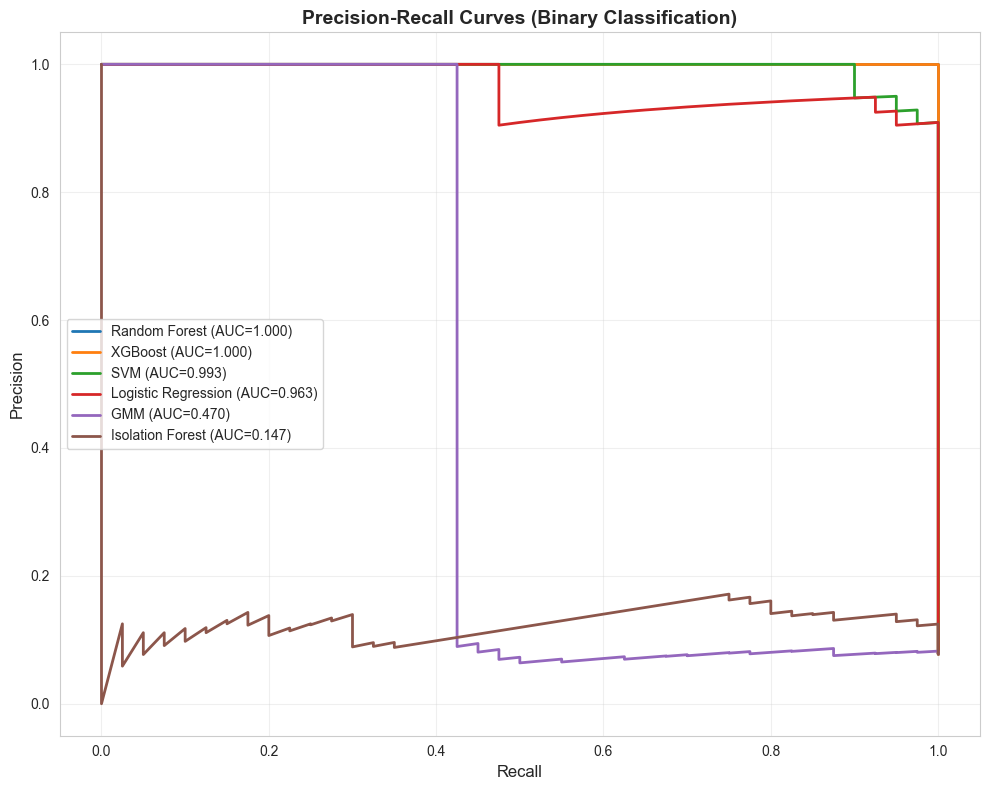

✓ Saved: roc_curves.png


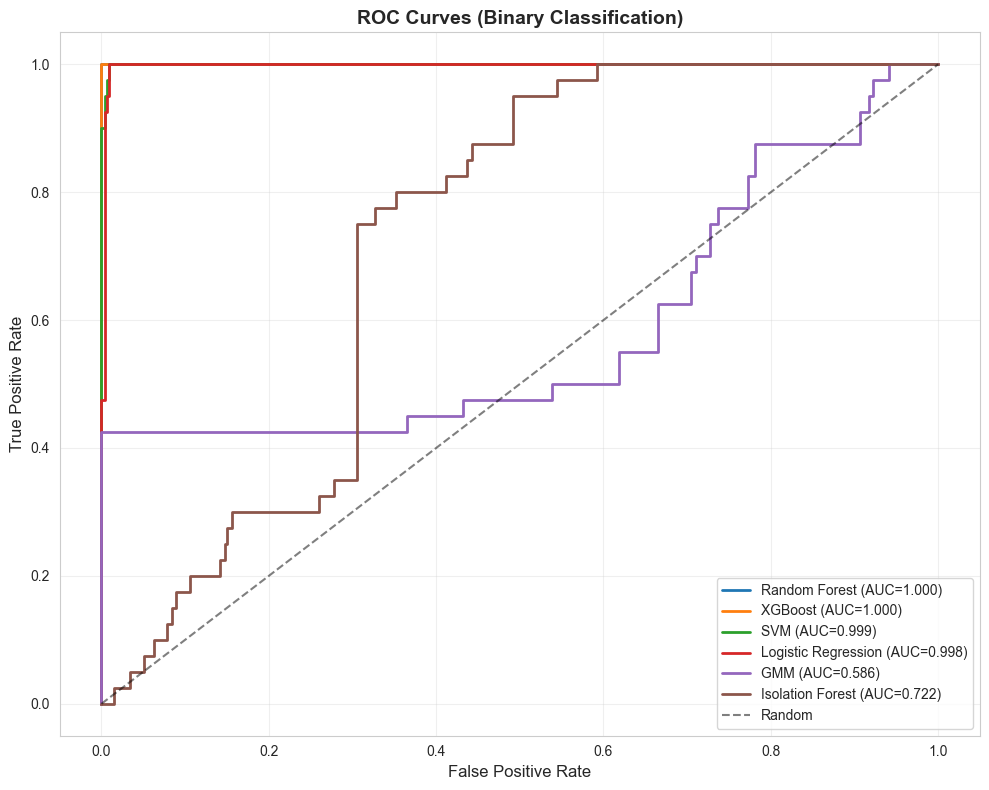

✓ Saved: metrics_comparison.png


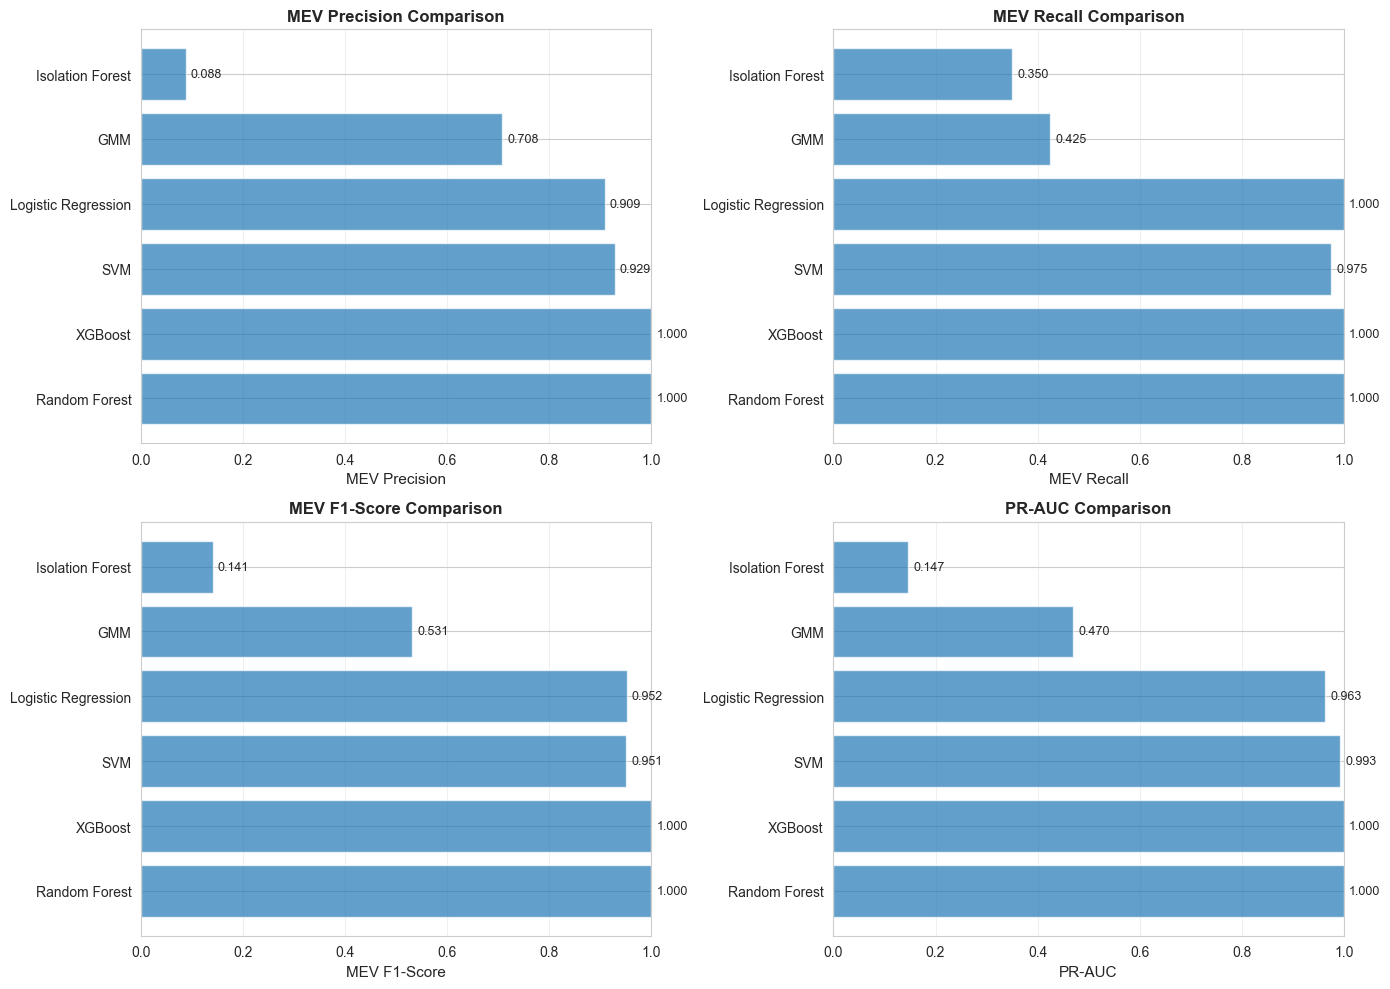


VISUALIZATIONS COMPLETE



In [6]:
# Visualizations
print("Creating visualizations...")

# 1. Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(models.keys()):
    if idx < len(axes):
        cm = confusion_matrix(y_test, predictions[model_name])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Non-MEV', 'MEV'],
                   yticklabels=['Non-MEV', 'MEV'])
        axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('derived/ml_results_binary/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrices.png")
plt.show()

# 2. Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

for model_name in models.keys():
    y_proba = probabilities[model_name]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ax.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.3f})', linewidth=2)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves (Binary Classification)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('derived/ml_results_binary/pr_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: pr_curves.png")
plt.show()

# 3. ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for model_name in models.keys():
    y_proba = probabilities[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves (Binary Classification)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('derived/ml_results_binary/roc_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: roc_curves.png")
plt.show()

# 4. Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['precision_mev', 'recall_mev', 'f1_mev', 'pr_auc']
metric_labels = ['MEV Precision', 'MEV Recall', 'MEV F1-Score', 'PR-AUC']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric].values
    model_names = results_df['model'].values
    
    bars = ax.barh(model_names, values, alpha=0.7)
    ax.set_xlabel(label, fontsize=11)
    ax.set_title(f'{label} Comparison', fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('derived/ml_results_binary/metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: metrics_comparison.png")
plt.show()

print()
print("="*80)
print("VISUALIZATIONS COMPLETE")
print("="*80)
print()

## 5. Monte Carlo Simulation - Model Stability

### Purpose:

Bootstrap validation to assess model stability and uncertainty in F1 scores. This helps understand:
- How robust the model is to different training samples
- Confidence intervals for MEV F1-score
- Model reliability for production use

### Method:

- **N=1000 bootstrap iterations**: Sample with replacement from training data
- **Train model on each bootstrap sample**: Use same hyperparameters
- **Evaluate on test set**: Calculate MEV F1-score
- **Calculate statistics**: Mean, 95% confidence interval

5. MONTE CARLO SIMULATION - MODEL STABILITY

Running Monte Carlo simulation for XGBoost...
This may take a few minutes...
  Iteration 100/1000...
  Iteration 200/1000...
  Iteration 300/1000...
  Iteration 400/1000...
  Iteration 500/1000...
  Iteration 600/1000...
  Iteration 700/1000...
  Iteration 800/1000...
  Iteration 900/1000...
  Iteration 1000/1000...

Monte Carlo Results:
  - Mean MEV F1: 0.9998
  - Std Dev: 0.0014
  - 95% CI: [1.0000, 1.0000]

✓ Saved: monte_carlo_f1_distribution.png


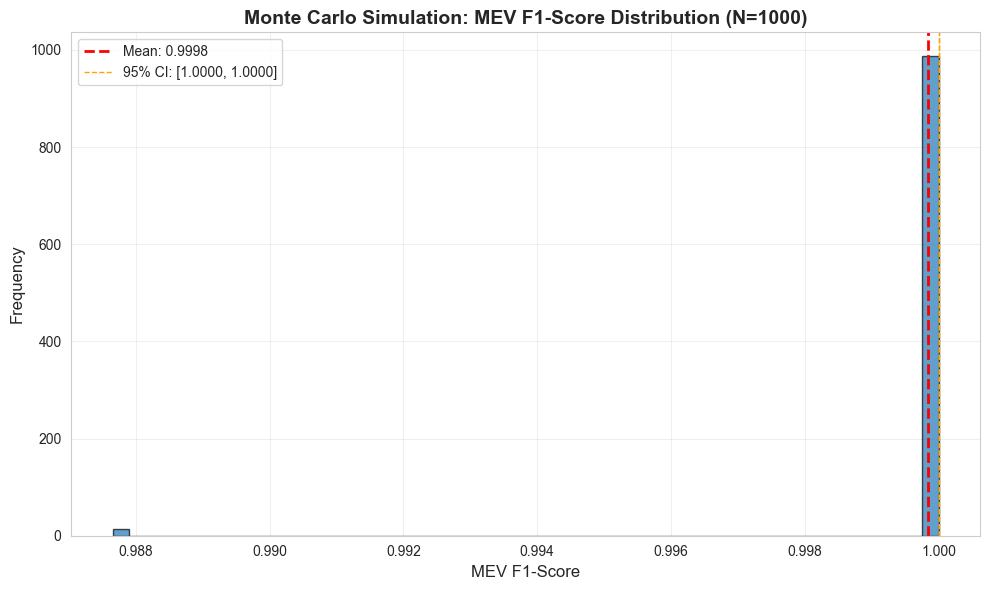

MONTE CARLO SIMULATION COMPLETE



In [7]:
print("="*80)
print("5. MONTE CARLO SIMULATION - MODEL STABILITY")
print("="*80)
print()

# Monte Carlo simulation for best model (XGBoost)
print("Running Monte Carlo simulation for XGBoost...")
print("This may take a few minutes...")

N = 1000  # Number of bootstrap iterations
f1_mev_bootstrap = []

np.random.seed(42)

for i in range(N):
    if (i + 1) % 100 == 0:
        print(f"  Iteration {i+1}/{N}...")
    
    # Bootstrap sample with replacement
    bootstrap_indices = np.random.choice(len(X_train_res), size=len(X_train_res), replace=True)
    X_boot = X_train_res[bootstrap_indices]
    y_boot = y_train_res[bootstrap_indices]
    
    # Train model on bootstrap sample
    boot_model = xgb.XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss'
    )
    boot_model.fit(X_boot, y_boot)
    
    # Predict on test set
    y_pred_boot = boot_model.predict(X_test_scaled)
    
    # Calculate MEV F1-score
    f1_mev = f1_score(y_test, y_pred_boot, pos_label=1, zero_division=0)
    f1_mev_bootstrap.append(f1_mev)

f1_mev_bootstrap = np.array(f1_mev_bootstrap)

# Calculate statistics
mean_f1 = np.mean(f1_mev_bootstrap)
std_f1 = np.std(f1_mev_bootstrap)
ci_95 = np.percentile(f1_mev_bootstrap, [2.5, 97.5])

print()
print("Monte Carlo Results:")
print(f"  - Mean MEV F1: {mean_f1:.4f}")
print(f"  - Std Dev: {std_f1:.4f}")
print(f"  - 95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(f1_mev_bootstrap, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.4f}')
ax.axvline(ci_95[0], color='orange', linestyle='--', linewidth=1, label=f'95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]')
ax.axvline(ci_95[1], color='orange', linestyle='--', linewidth=1)
ax.set_xlabel('MEV F1-Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Monte Carlo Simulation: MEV F1-Score Distribution (N=1000)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('derived/ml_results_binary/monte_carlo_f1_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: monte_carlo_f1_distribution.png")
plt.show()

print("="*80)
print("MONTE CARLO SIMULATION COMPLETE")
print("="*80)
print()

## 6. Parameter Optimization - GridSearchCV

### Purpose:

Find optimal hyperparameters for the best model (XGBoost) using cross-validation with F1-score as the metric.

### Grid Search Parameters:

- **max_depth**: Tree depth [3, 5, 7]
- **learning_rate**: Learning rate [0.01, 0.1, 0.2]
- **n_estimators**: Number of trees [100, 200]

### Scoring:

- **scoring='f1'**: Focus on MEV F1-score (pos_label=1)
- **cv=5**: 5-fold cross-validation

In [8]:
print("="*80)
print("6. PARAMETER OPTIMIZATION - GRIDSEARCHCV")
print("="*80)
print()

# Parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

print("Grid Search Parameters:")
for param, values in param_grid.items():
    print(f"  - {param}: {values}")
print()

# Create base model
base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss'
)

# Grid search with F1 scoring (for MEV class)
print("Running GridSearchCV (this may take several minutes)...")
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='f1',  # F1-score for MEV class (pos_label=1)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

print()
print("Grid Search Results:")
print(f"  - Best Parameters: {grid_search.best_params_}")
print(f"  - Best CV F1-Score: {grid_search.best_score_:.4f}")
print()

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

test_f1 = f1_score(y_test, y_pred_best, pos_label=1, zero_division=0)
test_precision = precision_score(y_test, y_pred_best, pos_label=1, zero_division=0)
test_recall = recall_score(y_test, y_pred_best, pos_label=1, zero_division=0)
test_pr_auc = average_precision_score(y_test, y_proba_best)

print("Best Model Performance on Test Set:")
print(f"  - MEV Precision: {test_precision:.4f}")
print(f"  - MEV Recall: {test_recall:.4f}")
print(f"  - MEV F1: {test_f1:.4f}")
print(f"  - PR-AUC: {test_pr_auc:.4f}")
print()

# Compare with original XGBoost
original_f1 = f1_score(y_test, y_pred_xgb, pos_label=1, zero_division=0)
improvement = test_f1 - original_f1

print("Comparison with Original XGBoost:")
print(f"  - Original F1: {original_f1:.4f}")
print(f"  - Optimized F1: {test_f1:.4f}")
print(f"  - Improvement: {improvement:+.4f}")
print()

# Save best model
models['XGBoost (Optimized)'] = best_model
predictions['XGBoost (Optimized)'] = y_pred_best
probabilities['XGBoost (Optimized)'] = y_proba_best

print("="*80)
print("PARAMETER OPTIMIZATION COMPLETE")
print("="*80)
print()

6. PARAMETER OPTIMIZATION - GRIDSEARCHCV

Grid Search Parameters:
  - max_depth: [3, 5, 7]
  - learning_rate: [0.01, 0.1, 0.2]
  - n_estimators: [100, 200]

Running GridSearchCV (this may take several minutes)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Grid Search Results:
  - Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  - Best CV F1-Score: 0.9995

Best Model Performance on Test Set:
  - MEV Precision: 1.0000
  - MEV Recall: 1.0000
  - MEV F1: 1.0000
  - PR-AUC: 1.0000

Comparison with Original XGBoost:
  - Original F1: 1.0000
  - Optimized F1: 1.0000
  - Improvement: +0.0000

PARAMETER OPTIMIZATION COMPLETE



## 7. Summary and Results Export

### Final Results:

- All models trained and evaluated
- Best model identified by F1-score and PR-AUC
- Monte Carlo simulation shows model stability
- Parameter optimization completed

### Output Files:

- `derived/ml_results_binary/confusion_matrices.png`
- `derived/ml_results_binary/pr_curves.png`
- `derived/ml_results_binary/roc_curves.png`
- `derived/ml_results_binary/metrics_comparison.png`
- `derived/ml_results_binary/monte_carlo_f1_distribution.png`
- `derived/ml_results_binary/results_summary.json`

In [9]:
print("="*80)
print("7. SUMMARY AND RESULTS EXPORT")
print("="*80)
print()

# Prepare summary data
summary = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_samples': len(df_clean_features),
        'mev_samples': int(np.sum(y == 1)),
        'non_mev_samples': int(np.sum(y == 0)),
        'imbalance_ratio': float(imbalance_ratio),
        'features': feature_cols
    },
    'models': {}
}

# Add model results
for model_name in models.keys():
    if model_name in predictions:
        y_pred = predictions[model_name]
        y_proba = probabilities[model_name]
        
        summary['models'][model_name] = {
            'accuracy': float(accuracy_score(y_test, y_pred)),
            'precision_mev': float(precision_score(y_test, y_pred, pos_label=1, zero_division=0)),
            'recall_mev': float(recall_score(y_test, y_pred, pos_label=1, zero_division=0)),
            'f1_mev': float(f1_score(y_test, y_pred, pos_label=1, zero_division=0)),
            'roc_auc': float(roc_auc_score(y_test, y_proba)) if len(np.unique(y_test)) > 1 else 0.0,
            'pr_auc': float(average_precision_score(y_test, y_proba))
        }

# Add Monte Carlo results
summary['monte_carlo'] = {
    'n_iterations': N,
    'mean_f1_mev': float(mean_f1),
    'std_f1_mev': float(std_f1),
    'ci_95_lower': float(ci_95[0]),
    'ci_95_upper': float(ci_95[1])
}

# Add grid search results
if 'grid_search' in locals():
    summary['grid_search'] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': float(grid_search.best_score_),
        'test_f1': float(test_f1),
        'test_pr_auc': float(test_pr_auc)
    }

# Save to JSON
output_file = 'derived/ml_results_binary/results_summary.json'
with open(output_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Results saved to: {output_file}")
print()

# Print final summary
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print()

print("Best Models:")
print(f"  - By MEV F1: {best_model_f1} (F1={best_f1:.4f})")
print(f"  - By PR-AUC: {best_model_pr} (PR-AUC={best_pr:.4f})")
print()

print("Target Goals:")
targets_met = []
if best_f1 > 0.5:
    targets_met.append("✓ MEV F1 > 0.5")
else:
    targets_met.append("✗ MEV F1 > 0.5 (current: {:.4f})".format(best_f1))

best_recall = results_df.loc[results_df['f1_mev'].idxmax(), 'recall_mev']
if best_recall > 0.7:
    targets_met.append("✓ MEV Recall > 0.7")
else:
    targets_met.append("✗ MEV Recall > 0.7 (current: {:.4f})".format(best_recall))

if best_pr > 0.6:
    targets_met.append("✓ PR-AUC > 0.6")
else:
    targets_met.append("✗ PR-AUC > 0.6 (current: {:.4f})".format(best_pr))

for target in targets_met:
    print(f"  {target}")

print()
print("Model Stability (Monte Carlo):")
print(f"  - Mean MEV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  - 95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
print()

print("="*80)
print("BINARY CLASSIFICATION ANALYSIS COMPLETE")
print("="*80)

7. SUMMARY AND RESULTS EXPORT

✓ Results saved to: derived/ml_results_binary/results_summary.json

FINAL SUMMARY

Best Models:
  - By MEV F1: Random Forest (F1=1.0000)
  - By PR-AUC: Random Forest (PR-AUC=1.0000)

Target Goals:
  ✓ MEV F1 > 0.5
  ✓ MEV Recall > 0.7
  ✓ PR-AUC > 0.6

Model Stability (Monte Carlo):
  - Mean MEV F1: 0.9998 ± 0.0014
  - 95% CI: [1.0000, 1.0000]

BINARY CLASSIFICATION ANALYSIS COMPLETE
